In [2]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import (
    DataCollatorForSeq2Seq,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    pipeline,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
) 
from datasets import load_dataset, load_metric
import torch
import nltk
nltk.download('punkt')

from tqdm import tqdm
import evaluate
import pickle


import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
DEVICE = torch.device('cuda:0')
PATH_DATA = "IlyaGusev/gazeta"
PATH_MBART = "IlyaGusev/mbart_ru_sum_gazeta"

# Загрузка датасета

In [7]:
dataset = load_dataset(PATH_DATA)

In [8]:
df = pd.DataFrame(dataset['test'])
df

,text,summary,title,date,url
0,На этих выходных в Берлине прошли крупные акци...,Протестующие против антикоронавирусных мер нем...,В Германии объяснили упоминание имени Путина н...,2020-09-01 00:22:59,https://www.gazeta.ru/politics/2020/08/31_a_13...
1,Высокопоставленная американская и израильская ...,"Делегации Израиля и США прилетели в ОАЭ, где о...",Делегации Израиля и США прибыли в ОАЭ для обсу...,2020-09-01 08:08:16,https://www.gazeta.ru/politics/2020/08/31_a_13...
2,Одна из руководителей Координационного совета ...,Белорусская оппозиция в лице экс-кандидата в п...,Оппозиция Белоруссии объявила о создании новой...,2020-09-01 09:21:38,https://www.gazeta.ru/politics/2020/09/01_a_13...
3,Россия считает действия ВС США во время учений...,Действия американских ВС в Эстонии во время уч...,Россия считает крайне опасными действия США на...,2020-09-01 09:33:30,https://www.gazeta.ru/army/2020/09/01/13222904...
4,С 1 сентября в России вступают в силу поправки...,Поправки в российский закон «О банкротстве» вс...,В России вступил в силу закон о внесудебном ба...,2020-09-01 09:49:24,https://www.gazeta.ru/business/2020/09/01/1322...
...,...,...,...,...,...
6788,Феерическим взрывом в атмосфере закончился пер...,Первый пуск американской частной ракеты Alpha ...,СМИ назвали успехом запуск частной ракеты Alph...,2021-09-03 09:28:34,https://www.gazeta.ru/science/2021/09/03_a_139...
6789,Глава Минвостокразвития Алексей Чекунков 31 ав...,Городская агломерация Владивостока может дости...,На ВЭФ подписано соглашение о создании города ...,2021-09-03 09:45:36,https://www.gazeta.ru/economics/2021/09/03/139...
6790,После взрывов во Врбетице отношения между Чехи...,Из-за геополитической и экономической роли Рос...,Глава чешского МИДа призвал восстанавливать св...,2021-09-03 10:44:03,https://www.gazeta.ru/politics/2021/09/03_a_13...
6791,Астрономы впервые наблюдали процесс вспышки св...,Международная группа астрономов впервые наблюд...,Астрономы наблюдали вспышку сверхновой нового ...,2021-09-03 11:43:50,https://www.gazeta.ru/science/2021/09/03_a_139...


In [9]:
N = len(df)

# Метрики

In [3]:
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Mbart

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
""" 
Загрузка модели
"""
model_name = PATH_MBART
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to(DEVICE)

In [9]:
score = []
predictions = []
for i, text in enumerate(pbar := tqdm(df['text'], total = N)):

    input_ids = tokenizer(
        text,
        max_length = 600,
        padding = "max_length",
        truncation = True,
        return_tensors = "pt",
    )["input_ids"]

    input_ids = input_ids.to(DEVICE)
    output_ids = model.generate(
        input_ids = input_ids,
        no_repeat_ngram_size = 4
    )[0]

    summary = tokenizer.decode(output_ids, skip_special_tokens=True)
    """
    Подсчет метрики для каждого предложения
    """
    result_bleu  = bleu.compute(predictions = list([summary]), references= [[df['summary'][i]]])
    result_rouge = rouge.compute(predictions = list([summary]), references= [[df['summary'][i]]])
    pbar.set_description('Sentence: {}, bleu: {}'.format(i, result))
    predictions.append(summary)

Sentence: 6792, bleu: {'bleu': 0.0, 'precisions': [0.2542372881355932, 0.034482758620689655, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.475, 'translation_length': 59, 'reference_length': 40}: 100%|██████████| 6793/6793 [2:15:04<00:00,  1.19s/it]                                                                                


In [10]:
""" 
Сохарняем предсказанные значения
"""
with open('predicts', 'wb') as file:
    pickle.dump(predictions, file)

In [4]:
""" 
При необходимости загружаем готовые значения
"""
# obj = pd.read_pickle(r'predicts')

In [11]:
""" 
Выводим среднее значение метрик для модели mBart
"""
mean_bleu_mbart = bleu.compute(predictions = predictions, references= df['summary'].values)
mean_rouge_mbart =  rouge.compute(predictions = predictions, references= df['summary'].values)

print('Среднее значение bleu модели MBart : ', mean_bleu_mbart['bleu'] * 100) 
print('Среднее значение rouge модели MBart : ', mean_rouge_mbart['rouge1'] * 100) 

Среднее значение bleu модели MBart :  8.499904392029368
Среднее значение rouge модели MBart :  22.409932389050695


# T5

In [12]:
""" 
Загрузка модели
"""
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")  
model = MT5ForConditionalGeneration.from_pretrained('google/mt5-small')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
max_target_tokens_count = 128
max_source_tokens_count = 1024

""" 
Функция для предобработки текстовых значений
"""
def preprocess_function(examples):
    inputs = examples["text"]
    model_inputs = tokenizer(inputs, max_length=max_source_tokens_count, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=max_target_tokens_count, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

In [14]:
""" 
Токенизируем наши данные
"""
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [15]:
""" 
Оправляем наши токены в модель
"""
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [16]:
""" 
Функция для подсчета метрик нашей модели
"""
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens = True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = {}
    result_rouge = rouge.compute(predictions = decoded_preds, references = decoded_labels)
    result.update({key: value * 100 for key, value in result_rouge.items()})

    result_bleu = bleu.compute(predictions = decoded_preds, references = decoded_labels)
    result["bleu"] = result_bleu["bleu"] * 100

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    result["char_len"] = np.mean([len(t) for t in decoded_preds])

    return {k: round(v, 4) for k, v in result.items()}


In [17]:
"""
Задаем гиперпараметры 
"""
training_args = Seq2SeqTrainingArguments(
    output_dir = "t5", # директория для сохранения прогнозов модели и контрольных точек
    evaluation_strategy = "steps",
    eval_steps = 25, # количество шагов обновления между двумя оценками, если evaluation_strategy="steps"
    logging_steps = 25,
    learning_rate = 4e-4, # начальная скорость обучения
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps = 64, # количество шагов обновления, для которых нужно накопить градиенты, перед выполнением обратного прохода/обновления
    weight_decay = 0.01, # снижение веса
    save_total_limit = 3, # общее количество контрольных точек
    num_train_epochs = 1, # количество эпох
    fp16 = False, # использовать ли 16-битное обучение
    predict_with_generate = True,
    generation_max_length = max_target_tokens_count, # максимальная длина предсказанного предложения
    generation_num_beams = 5 
)

In [18]:
"""
Объявляем цикл обучения, который специально оптимизирован для моделек-трансформеров
"""
trainer = Seq2SeqTrainer(
    model = model, # наша базовая модель
    args = training_args, # гиперпараметры модели
    train_dataset = tokenized_dataset["train"].select(range(1000)), # набор данных для обучения
    eval_dataset = tokenized_dataset["test"].select(range(300)), # набор данных для тестирования модели
    tokenizer = tokenizer, # токенизатор для прдварительной обработки данных
    data_collator = data_collator, # функция, используемая для формирования пакета из списка элементов train_datasetили eval_dataset
    compute_metrics = compute_metrics # функция для вычисления метрик
)

In [19]:
""" 
Обучение модели
"""
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=3, training_loss=18.24051284790039, metrics={'train_runtime': 72.1428, 'train_samples_per_second': 13.861, 'train_steps_per_second': 0.042, 'total_flos': 811333353799680.0, 'train_loss': 18.24051284790039, 'epoch': 0.77})

In [20]:
""" 
Тестирование модели
"""
result = trainer.evaluate()

In [21]:
"""
Значение метрик для модели T5
"""
print(result)

{'eval_loss': 9.208014488220215, 'eval_rouge1': 2.3497, 'eval_rouge2': 0.5859, 'eval_rougeL': 2.3949, 'eval_rougeLsum': 2.3844, 'eval_bleu': 0.9158, 'eval_gen_len': 34.75, 'eval_char_len': 108.4667, 'eval_runtime': 203.395, 'eval_samples_per_second': 1.475, 'eval_steps_per_second': 0.369, 'epoch': 0.77}


# Сравнение метрик

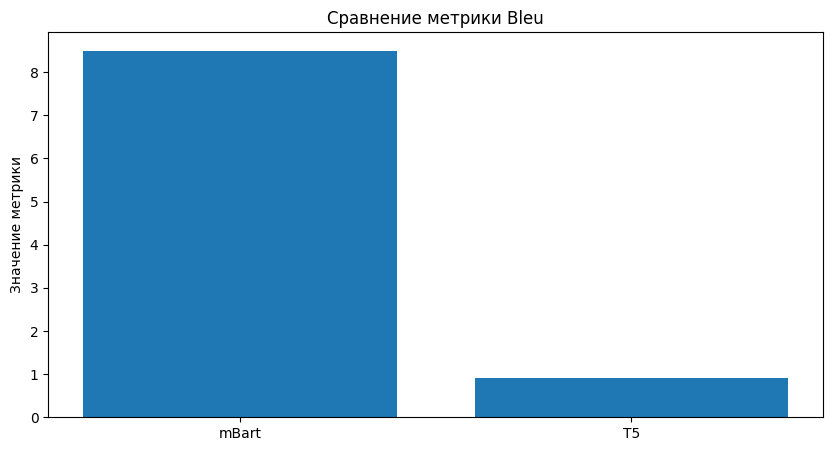

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))


models = ['mBart', 'T5']
values = [mean_bleu_mbart['bleu'] * 100, result['eval_bleu']]

ax.bar(models, values)

ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрики Bleu')

plt.show()

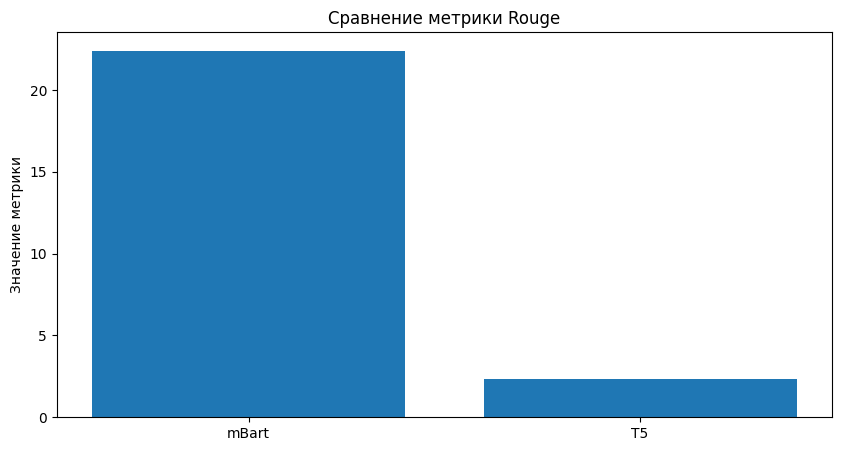

In [11]:
fig, ax = plt.subplots(figsize = (10, 5))

models = ['mBart', 'T5']
values = [mean_bleu_mbart['bleu'] * 100, result['eval_rouge1']]

ax.bar(models, values)

ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрики Rouge')

plt.show()